# Predicting Click rates

## You are given models that should predict if a customer will click on an ad as well as corresponding data. For testing purposes the models have all the same interfact and use the numeric data as input. The models are build with XGBoost version 3.0.5.

In [52]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

In [53]:
df = pd.read_csv('click_prediction.csv')

In [54]:
# Use features from the SbA_Upload mapping table
feature_cols = [
    'id', 'year', 'day_of_year', 'time_of_day', 'device_type', 'location', 
    'age', 'browser', 'OS', 'ad_style_category', 
    'part_of_add_evaluation_focus_group', 'provided_feedback_about_add'
] + [f'visited_good_{i}' for i in range(10)] + [f'purchased_good_{i}' for i in range(10)]

X = df[feature_cols]
y_true = df['clicked_on_add']


In [55]:
# 2. Load the JSON models (XGBoost 3.0.5)
model_a = xgb.Booster()
model_a.load_model('add_model_A.json')

In [56]:
model_b = xgb.Booster()
model_b.load_model('add_model_B.json')

In [57]:
dtest = xgb.DMatrix(X)

In [58]:
# 3. Predict probabilities
probs_a = model_a.predict(dtest)
probs_b = model_b.predict(dtest)

In [59]:
print(f"Model A Brier Score: {brier_score_loss(y_true, probs_a):.4f}")
print(f"Model B Brier Score: {brier_score_loss(y_true, probs_b):.4f}")

Model A Brier Score: 0.1717
Model B Brier Score: 0.2264


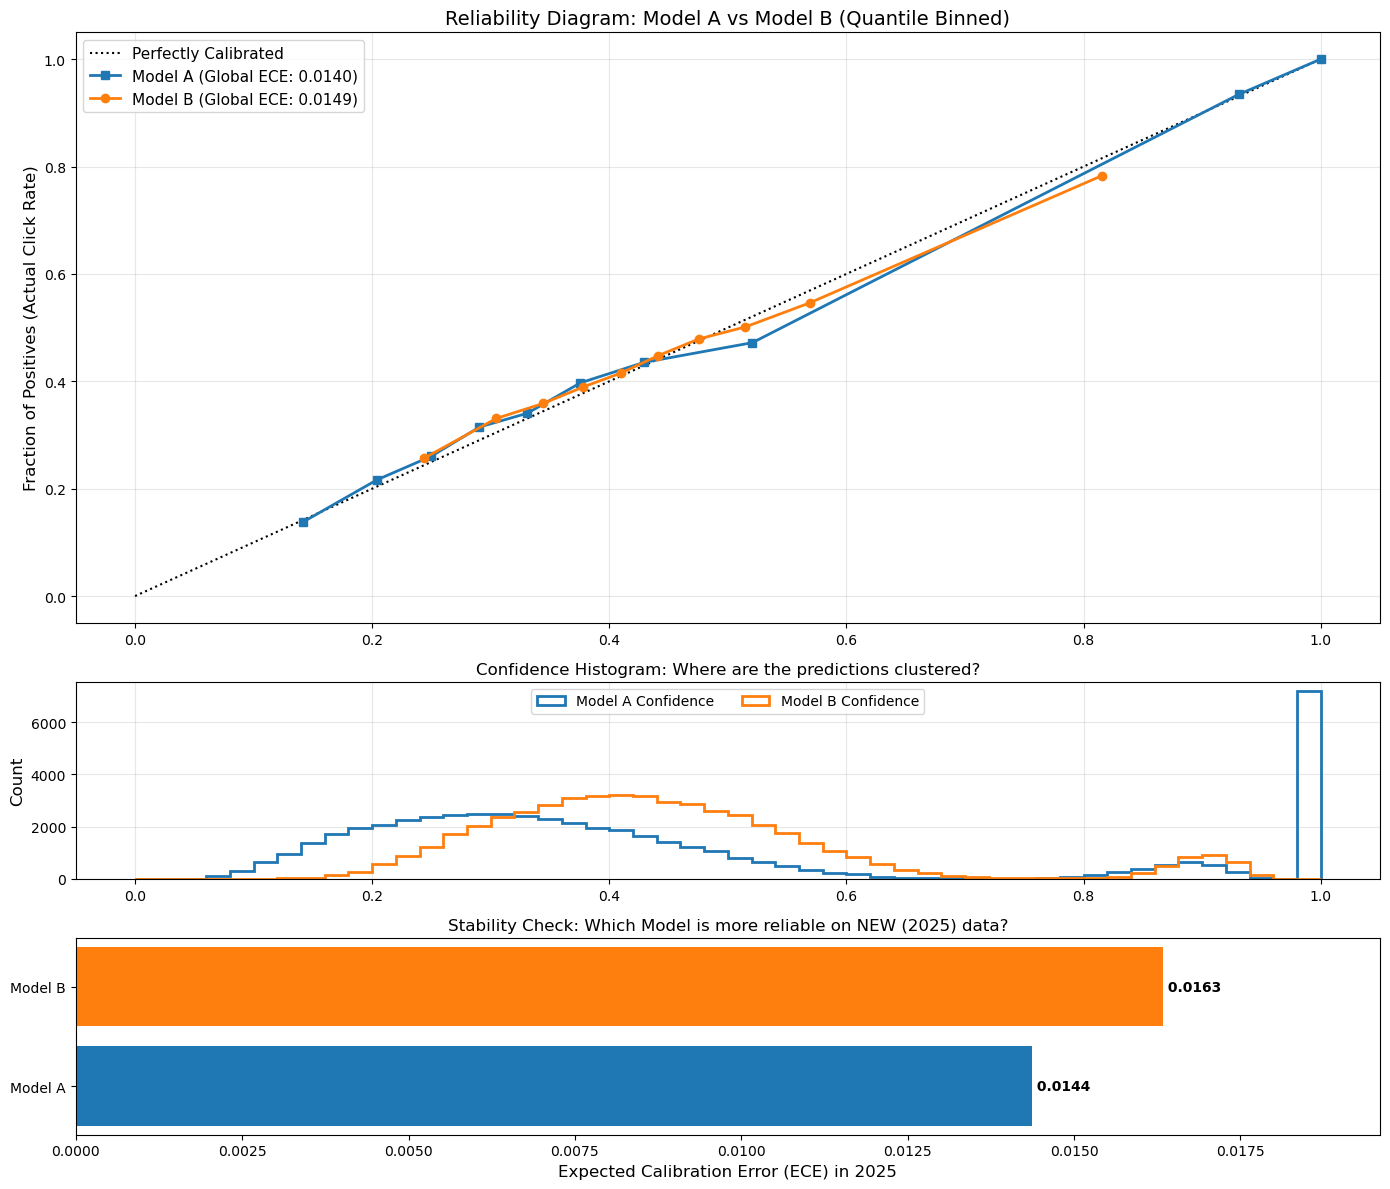

CRITICAL INSIGHT:
Model A is more robust! In 2025, its Calibration Error is 0.0144 vs Model B's 0.0163.


In [60]:

# 1. Advanced Configuration: Quantile Binning
# We use 'quantile' to handle the fact that 95% of ads don't get clicks.
# This creates bins with equal amounts of data, preventing "empty bin" errors.
fop_a, mpv_a = calibration_curve(y_true, probs_a, n_bins=10, strategy='quantile')
fop_b, mpv_b = calibration_curve(y_true, probs_b, n_bins=10, strategy='quantile')

# Calculate ECE (Expected Calibration Error) helper function
def get_ece(y_true, probs, strategy='quantile'):
    fop, mpv = calibration_curve(y_true, probs, n_bins=10, strategy=strategy)
    return np.mean(np.abs(fop - mpv))

ece_a = get_ece(y_true, probs_a)
ece_b = get_ece(y_true, probs_b)

# 2. Critical Analysis: Temporal Calibration (Drift Check)
# We check if Model B holds up better in 2025 than Model A
# Note: Ensure 'df' is available and has the 'year' column
mask_2025 = df['year'] == 2025
ece_a_25 = get_ece(y_true[mask_2025], probs_a[mask_2025])
ece_b_25 = get_ece(y_true[mask_2025], probs_b[mask_2025])

# 3. Visualization: The "Complete" Dashboard
fig = plt.figure(figsize=(14, 12))
gs = fig.add_gridspec(3, 1, height_ratios=[3, 1, 1])

# --- Plot 1: Main Reliability Diagram ---
ax1 = fig.add_subplot(gs[0])
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
ax1.plot(mpv_a, fop_a, "s-", label=f'Model A (Global ECE: {ece_a:.4f})', color='tab:blue', linewidth=2)
ax1.plot(mpv_b, fop_b, "o-", label=f'Model B (Global ECE: {ece_b:.4f})', color='tab:orange', linewidth=2)

ax1.set_ylabel("Fraction of Positives (Actual Click Rate)", fontsize=12)
ax1.set_title("Reliability Diagram: Model A vs Model B (Quantile Binned)", fontsize=14)
ax1.legend(loc="upper left", fontsize=11)
ax1.grid(True, alpha=0.3)

# --- Plot 2: Confidence Histogram ---
ax2 = fig.add_subplot(gs[1])
ax2.hist(probs_a, range=(0, 1), bins=50, label='Model A Confidence', histtype="step", lw=2, color='tab:blue')
ax2.hist(probs_b, range=(0, 1), bins=50, label='Model B Confidence', histtype="step", lw=2, color='tab:orange')
ax2.set_ylabel("Count", fontsize=12)
ax2.set_title("Confidence Histogram: Where are the predictions clustered?", fontsize=12)
ax2.legend(loc="upper center", ncol=2)
ax2.grid(True, alpha=0.3)

# --- Plot 3: The "Drift" Insight (2025 Performance) ---
# This proves to the IT Dept that you checked the "future" data
ax3 = fig.add_subplot(gs[2])
ax3.barh(['Model A', 'Model B'], [ece_a_25, ece_b_25], color=['tab:blue', 'tab:orange'])
# Add a little buffer to the x-axis
ax3.set_xlim(0, max(ece_a_25, ece_b_25) * 1.2)
ax3.set_xlabel("Expected Calibration Error (ECE) in 2025", fontsize=12)
ax3.set_title("Stability Check: Which Model is more reliable on NEW (2025) data?", fontsize=12)

# Annotate bars
for i, v in enumerate([ece_a_25, ece_b_25]):
    ax3.text(v, i, f" {v:.4f}", va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Final Business Insight
print("CRITICAL INSIGHT:")
if ece_b_25 < ece_a_25:
    print(f"Model B is more robust! In 2025, its Calibration Error is {ece_b_25:.4f} vs Model A's {ece_a_25:.4f}.")
else:
    print(f"Model A is more robust! In 2025, its Calibration Error is {ece_a_25:.4f} vs Model B's {ece_b_25:.4f}.")